In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pandas as pd

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation/')
sys.path.append('../../')

import hts_fitting as hts, hts_showcase as sc, seaborn as sns, hts_fitfunctions as ff
from uncertainties import ufloat
from scipy import constants, optimize
from scipy.interpolate import interp1d
import default_style

def linear_norm(x, a):
    return a*x+1
    
savedir = '/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 6/figures/raw/'

## Deflection

In [2]:
def get_B_field(z=0):
    data = pd.read_csv('flux_density_norm_above_tape.txt', sep='\s+', skiprows=8, names=['y_m', 'field_T'])
    data['y_m'] -= data['y_m'].max()
    data['y_m'] = data.y_m.abs()
    data['field_T'] /= data['field_T'].max()
    return interp1d(data.y_m, data.field_T, fill_value=1., bounds_error=False, kind='cubic')(z)


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_83915/217611613.py:2: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv('flux_density_norm_above_tape.txt', sep='\s+', skiprows=8, names=['y_m', 'field_T'])


In [3]:
# Constants
q = constants.electron_volt           # Proton charge (C)
m = constants.atomic_mass             # Proton mass (kg)
initial_energy = 1200e3 * q           # Initial kinetic energy in joules
energy_loss_per_m = 100e3 * q / 1e-6  # 100 keV/um in J/m
field_start_z = 0                     # Field starts at z0 (downward)
tape_start_z = 0.04                   # The particle starts at y = 4 cm above the tape where the field is 1% of the maximum

# Initial conditions
r = np.array([0.0, 0.0, 0.0])              # Start at z = 0
v_mag = np.sqrt(2 * initial_energy / m)
v = np.array([0.0, 0.0, v_mag])           # Initial velocity in -z

# Time step and max steps
max_steps, step, dt = 300000, 1, 1e-14 #1e-14  # s

# Preallocate trajectory array
trajectory = np.zeros((max_steps, 3))
trajectory[0] = r.copy()

# Simulation loop
kinetic_energies = []
while np.linalg.norm(v) > 0 and step < max_steps:

    KE = 0.5 * m * np.linalg.norm(v)**2

    # Energy loss
    dz = v[2] * dt
    if r[2] >= tape_start_z:
        KE -= energy_loss_per_m * abs(dz)
        
    if KE <= 0:
        break

    # Update velocity magnitude
    v_mag = np.sqrt(2 * KE / m)
    v_dir = v / np.linalg.norm(v)
    v = v_mag * v_dir

    B = np.array([get_B_field(r[2]), 0.0, 0.0])  # Field in x-direction

    # Lorentz force
    a = q * np.cross(v, B) / m

    # Euler update
    v += a * dt
    r += v * dt

    trajectory[step] = r.copy()
    step += 1
    #if step%1000 == 0:
    #    print(step)
    kinetic_energies.append(KE)
    
# Trim unused part of trajectory
trajectory = trajectory[:step]

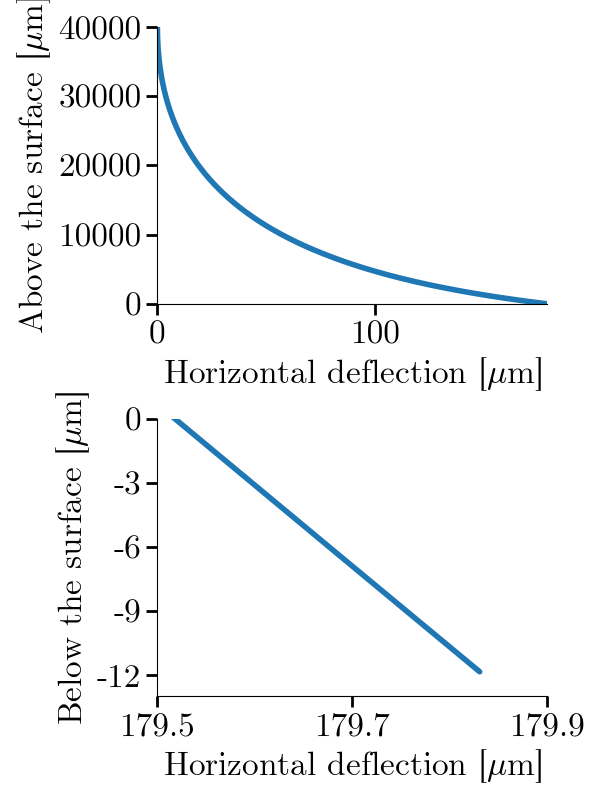

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
#ax[0].set_xlim(0, 200)
#ax[1].set_xlim(0, 1)
#ax[0].set_ylim(-0.5, 4)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
#ax[0].axhline(color='k', linewidth=1)
x = trajectory[:, 1]*1e6 # m to um
y = trajectory[:, 2]*1e2 # m to cm
y = np.abs(y-y.max())-(y.max()-4)

ax[0].plot(x, y*1e4, linewidth=4, solid_capstyle='round')  # z vs y
ax[0].set_xlabel(r'Horizontal deflection [$\mu$m]')
ax[0].set_ylabel(r'Above the surface [$\mu$m]')

ax[0].set_ylim(0, 4e4)
ax[0].set_xlim(0, 179.5)

ax[1].plot(x, y*1e4, linewidth=4, solid_capstyle='round')  # z vs y
ax[1].set_xlabel(r'Horizontal deflection [$\mu$m]')
ax[1].set_ylabel(r'Below the surface [$\mu$m]')
ax[1].set_xlim(179.5, 179.9)
ax[1].set_ylim(-13, 0)
ax[1].set_yticks([-12, -9, -6, -3, 0])
ax[1].set_xticks([179.5, 179.7, 179.9])

#x = field_vs_y.field_T/field_vs_y.field_T.iloc[0]
#y = (field_vs_y.y_m - field_vs_y.y_m.min())*1e2

#ax[1].plot(x, y, marker='o', linestyle='None', mec='magenta', mfc='white')  # z vs y linewidth=4, solid_capstyle='round'
#ax[1].set_xlabel(r'$\mathrm{H^{ext} \, / \, H^{surface}}$')
#ax[1].grid(False)

fig.tight_layout()
plt.savefig(savedir+'deflection.svg', format='svg', transparent=True, dpi=300)

## Permanent Magnet Field

/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_34297/3000356350.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_Hy = pd.read_csv(path+'Hy.txt', skiprows=8, usecols=[0, 1], names=['x', 'H'], delim_whitespace=True)
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_34297/3000356350.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_Hx = pd.read_csv(path+'Hx.txt', skiprows=8, usecols=[0, 1], names=['x', 'H'], delim_whitespace=True)


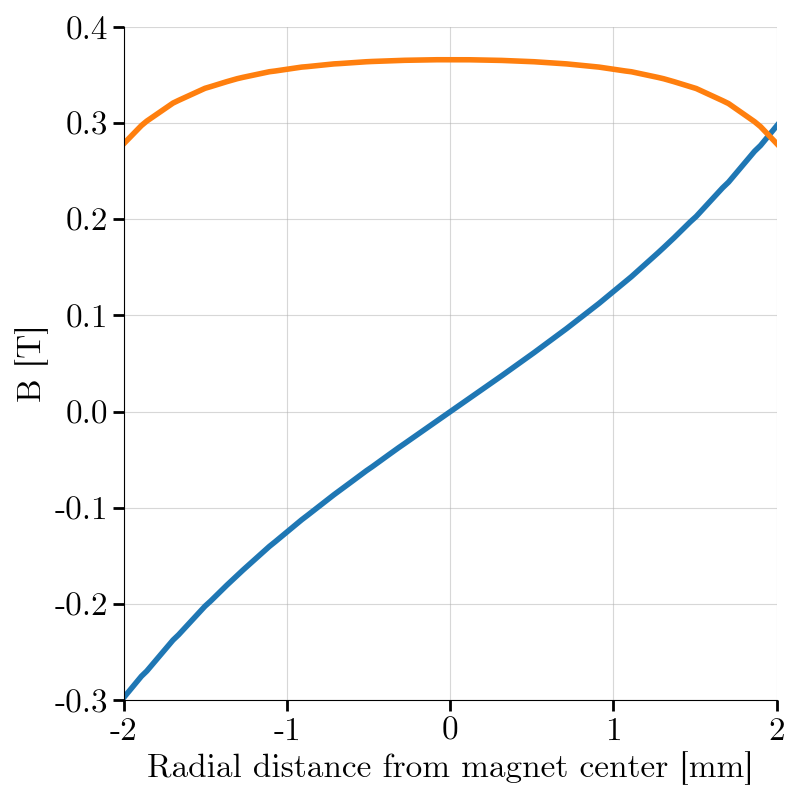

In [4]:
path = '/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 6/data/input/'
data_Hy = pd.read_csv(path+'Hy.txt', skiprows=8, usecols=[0, 1], names=['x', 'H'], delim_whitespace=True)
data_Hx = pd.read_csv(path+'Hx.txt', skiprows=8, usecols=[0, 1], names=['x', 'H'], delim_whitespace=True)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(data_Hx.x, data_Hx.H, linewidth=4)
ax.plot(data_Hy.x, data_Hy.H, linewidth=4)
ax.set_xlim(-2, 2)
ax.set_ylim(-.3, .4)
ax.grid(alpha=.5)

ax.set_xlabel('Radial distance from magnet center [mm]')
ax.set_ylabel('B [T]')
fig.tight_layout()

plt.savefig(savedir+'permanent_magnet_field.png', transparent=True, dpi=300)

## Vertical component of the permanent magnet field measured as a function of temperature

## Ic versus temperature for pristine sample ffj50

Measured in self field, at 0.33 T and a slightly lower field obtained by mounting the sample on a thicker sapphire plate.

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_13110/352523502.py:2: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('$\mathrm{I_c}$(T) [A]')
/Users/alexisdevitre/Documents/code/hts-irradiation/hts_fitting.py:578: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregates = data[cut].drop('fpath', axis=1).groupby(['temperature_group']).agg(['mean', 'std', 'count']).dropna()
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_13110/352523502.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

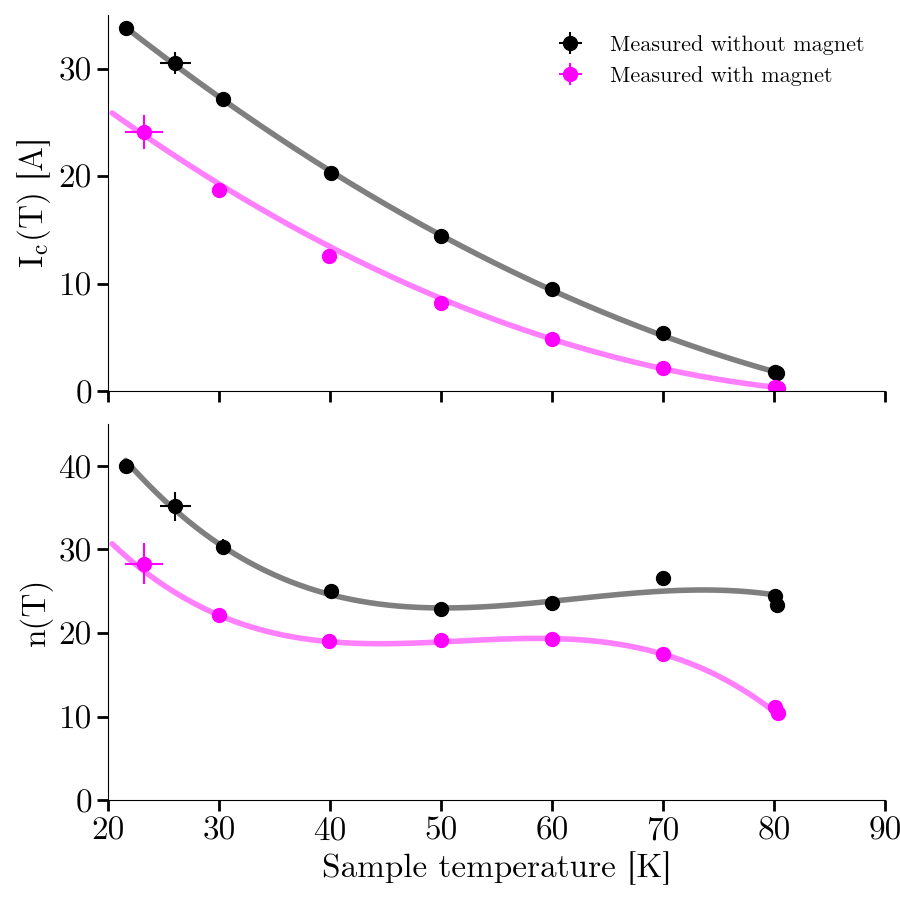

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(9, 9), sharex=True)
ax[0].set_ylabel('$\mathrm{I_c}$(T) [A]')
ax[1].set_ylabel('n(T)')
ax[1].set_xlabel('Sample temperature [K]')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylim(0, 35)
ax[1].set_ylim(0, 45)
ax[0].set_xlim(20, 90)

top = 'ext_ffj51/Ic/infield/step00/'

ysmooth_n_woH, ysmooth_ic_woH = [], []
for i, (path, l) in enumerate(zip([top+path for path in ['no magnet/', 'magnet/']], ['Measured without magnet', 'Measured with magnet'])):

    _, _, data, popt_ic, popt_n = hts.getIcT([path+f for f in np.sort(os.listdir(path)) if 'Ic' in f], function='powerLaw', fit=True)
    data['temperature_group'] = pd.cut(data['temperature'], bins=np.arange(0.3, 93.6, 5), right=False)
    
    means = data.drop('fpath', axis=1).groupby('temperature_group').mean()
    stds = data.drop('fpath', axis=1).groupby('temperature_group').std()
    
    if i == 0:
        c, m = 'k', 'o'
    else:
        c, m ='magenta', 'o'

    xsmooth = np.linspace(data.temperature.max(), data.temperature.min(), 1000)
    ysmooth_ic, ysmooth_n = ff.quadratic(xsmooth, *popt_ic), ff.cubic(xsmooth, *popt_n)
    ax[0].plot(xsmooth, ysmooth_ic, color=c, linewidth=4, solid_capstyle='round', alpha=.5)
    ax[1].plot(xsmooth, ysmooth_n, color=c, linewidth=4, solid_capstyle='round', alpha=.5)
    ax[0].errorbar(x=means.temperature, xerr=stds.temperature, y=means.ic, yerr=stds.ic, linestyle='None', marker=m, color=c, label=l)
    ax[1].errorbar(x=means.temperature, xerr=stds.temperature, y=means.n, yerr=stds.n, linestyle='None', marker=m, color=c, label=l)

    ysmooth_ic_woH.append(ysmooth_ic)
    ysmooth_n_woH.append(ysmooth_n)
    
ax[0].legend(loc='upper right', frameon=False, fontsize=16)
fig.tight_layout()
fig.savefig(savedir+'icnt_mag_nomag.svg', format='svg', transparent=True, dpi=300)

In [66]:
percent_change_ic = 100*(ysmooth_ic_woH[0]-ysmooth_ic_woH[1])/ysmooth_ic_woH[0]
percent_change_n  = 100*(ysmooth_n_woH[0]-ysmooth_n_woH[1])/ysmooth_n_woH[0]

np.mean(percent_change_ic), np.std(percent_change_ic), np.mean(percent_change_n), np.std(percent_change_n)

(np.float64(33.27271383900383),
 np.float64(5.005698110466928),
 np.float64(24.184919501419397),
 np.float64(3.9462037735789868))

## Superconducting transition with magnet

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_13110/2367790269.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Voltage [$\mu$V]')
/Users/alexisdevitre/Documents/code/hts-irradiation/hts_fitting.py:161: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(fpath, usecols=cols, skiprows=2, delim_whitespace=True, names=names)
/Users/alexisdevitre/Documents/code/hts-irradiation/hts_fitting.py:161: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(fpath, usecols=cols, skiprows=2, delim_whitespace=True, names=names)
/Users/alexisdevitre/Documents/code/hts-irradiation/hts_fitting.py:161: FutureWarning: The 'delim_whitespace' keyword in pd.read_c

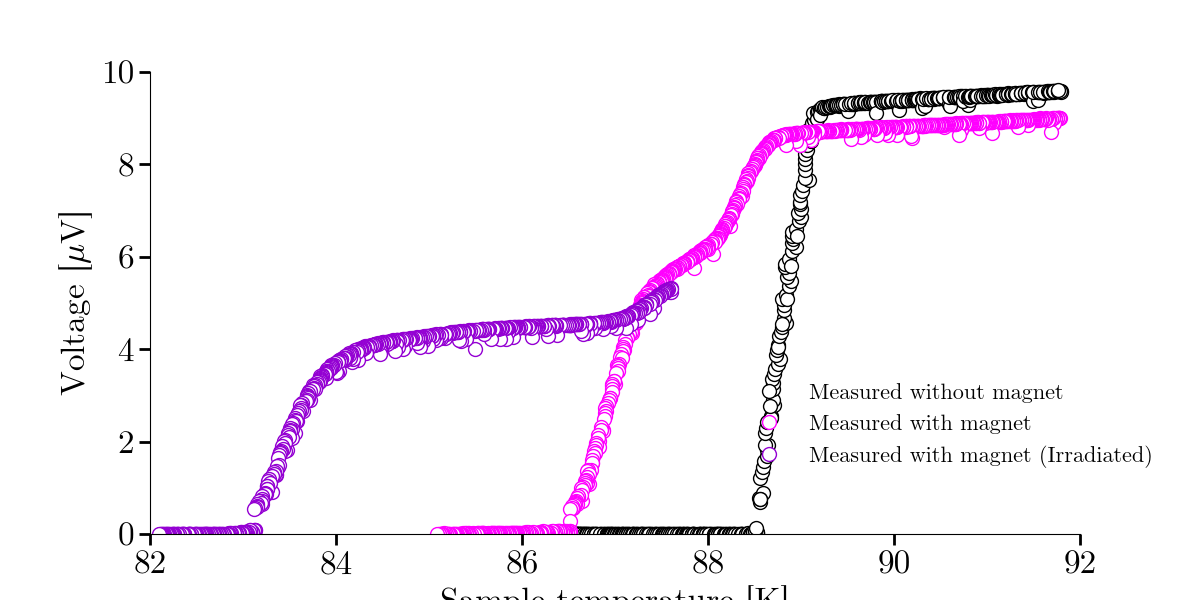

In [7]:
path = 'ext_ffj51/Tc/infield/'

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('Voltage [$\mu$V]')
ax.set_xlabel('Sample temperature [K]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 10)
ax.set_xlim(82, 92)

fnames = [
    'Tc_2025-03-06_19-39-41549956_ffj51-step00-nomagnet-up.txt',
    'Tc_2025-03-26_20-45-07747039_ffj51-step00-magnet-dn.txt',
    'Tc_2025-03-28_12-49-13960962_ffj51-step03-magnet-anneal300k-720min-dn.txt'
]

for i, f in enumerate(fnames):
    data = hts.readTV(path+f)
    cut = data.sampleT < 91.8
    if i == 0:
        c, m, l = 'k', 'o', 'Measured without magnet'
    elif i == 1:
        c, m, l = 'magenta', 'o', 'Measured with magnet'
    else:
        c, m, l = 'darkviolet', 'o', 'Measured with magnet (Irradiated)'
        
    ax.plot(data.sampleT[cut], 1e6*data.voltage[cut], linestyle='None', marker=m, label=l, color=c, mfc='white')

ax.legend(loc='lower right', frameon=False, bbox_to_anchor = (1.1, 0.1))
plt.savefig(savedir+'tc_mag_nomag.svg', format='svg', transparent=True, dpi=300)

<IPython.core.display.Javascript object>


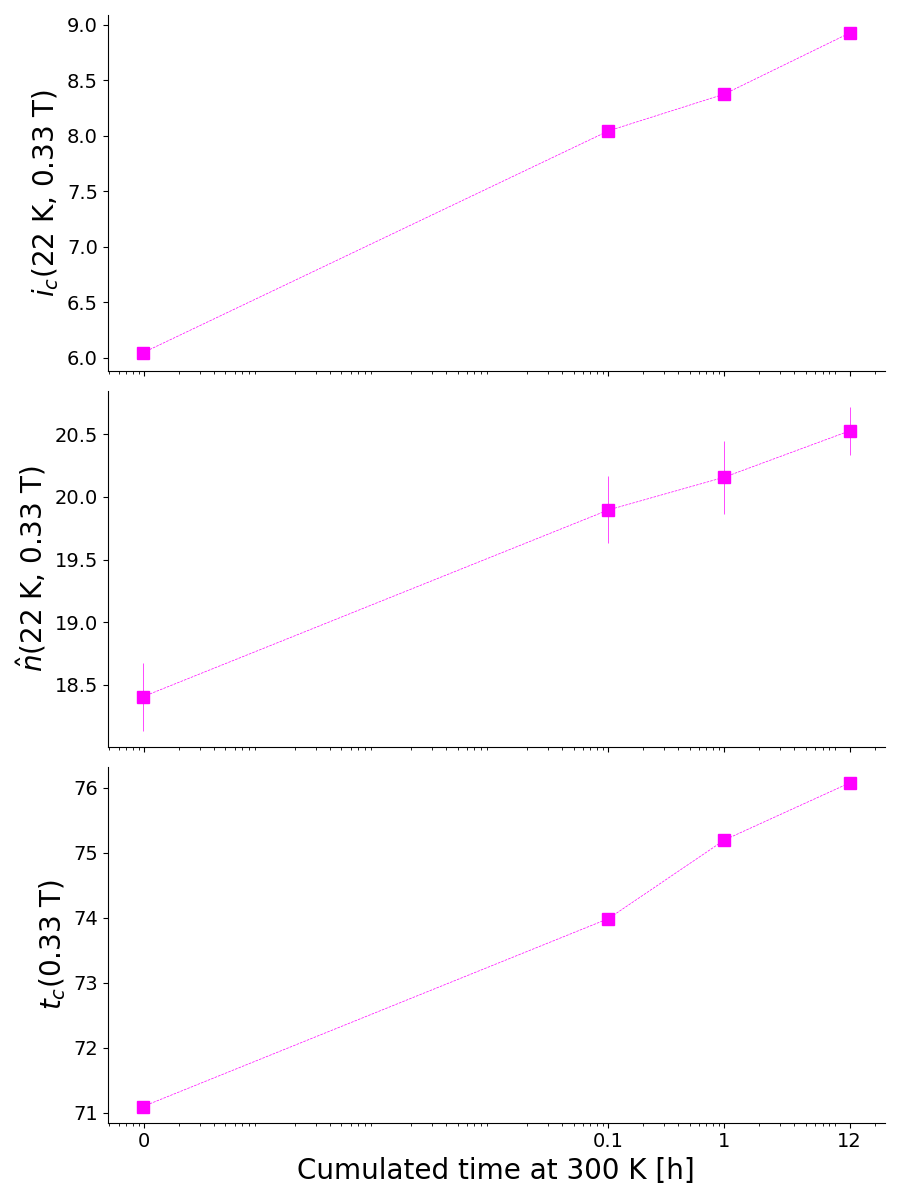

In [2]:
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)
ax[0].set_ylabel('$i_c$(22 K, 0.33 T)')
ax[1].set_ylabel('$\hat{n}$(22 K, 0.33 T)')
ax[2].set_ylabel('$t_c$(0.33 T)')
ax[2].set_xlabel('Cumulated time at 300 K [h]')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

#ax[0].set_ylim(0, 35)
#ax[1].set_ylim(0, 45)
#ax[0].set_xlim(1e-3, 1e5)


top = '/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 6/data/log-linear recovery/'

x = np.array([3500e-5, 360, 3600, 720*60])/3600
icmeans, icstds, nmeans, nstds, tc = [], [], [], [], []
for path in ['Ic/0min/', 'Ic/6min/', 'Ic/60min/', 'Ic/720min/']:
    data = hts.getIcT([top+path+f for f in np.sort(os.listdir(top+path)) if 'Ic' in f], function='powerLaw')[2]
    icmeans.append(data.ic.mean())
    icstds.append(data.ic.std())
    nmeans.append(data.n.mean())
    nstds.append(data.n.std())

ax[0].errorbar(x=x, y=icmeans, yerr=icstds, marker='s', linestyle='--', linewidth=.5, color='magenta')
ax[1].errorbar(x=x, y=nmeans, yerr=nstds, marker='s', linestyle='--', linewidth=.5, color='magenta')

for fpath in [top+'Tc/'+f for f in np.sort(os.listdir(top+'Tc/')) if 'Tc' in f]:    
    data = hts.readTV(fpath)
    data = data[data.sampleT < 79]
    tc.append(hts.fitTcMeasurement(fpath, fit_range=(70, 79), wsz=15))
    
ax[2].plot(x, tc, marker='s', linestyle='--', linewidth=.5, color='magenta')

plt.xscale('log')
ax[0].set_xticks([1e-5, 0.1, 1, 12])
ax[0].set_xticklabels(['0', '0.1', '1', '12'])

fig.tight_layout()

plt.savefig(savedir+'log-linear-recovery.png', transparent=True, dpi=300)

<>:97: SyntaxWarning: invalid escape sequence '\;'
<>:97: SyntaxWarning: invalid escape sequence '\;'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_65228/1302418053.py:97: SyntaxWarning: invalid escape sequence '\;'
  fig2.text(0.5, 0.04, 'Fluence [10$^{20}\; m^{-2}$]', ha='center', fontsize=16)
/Users/alexisdevitre/Documents/code/hts-irradiation/hts_fitting.py:579: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregates = data[cut].drop('fpath', axis=1).groupby(['temperature_group']).agg(['mean', 'std', 'count']).dropna()
/Users/alexisdevitre/Documents/code/hts-irradiation/hts_fitting.py:579: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt th

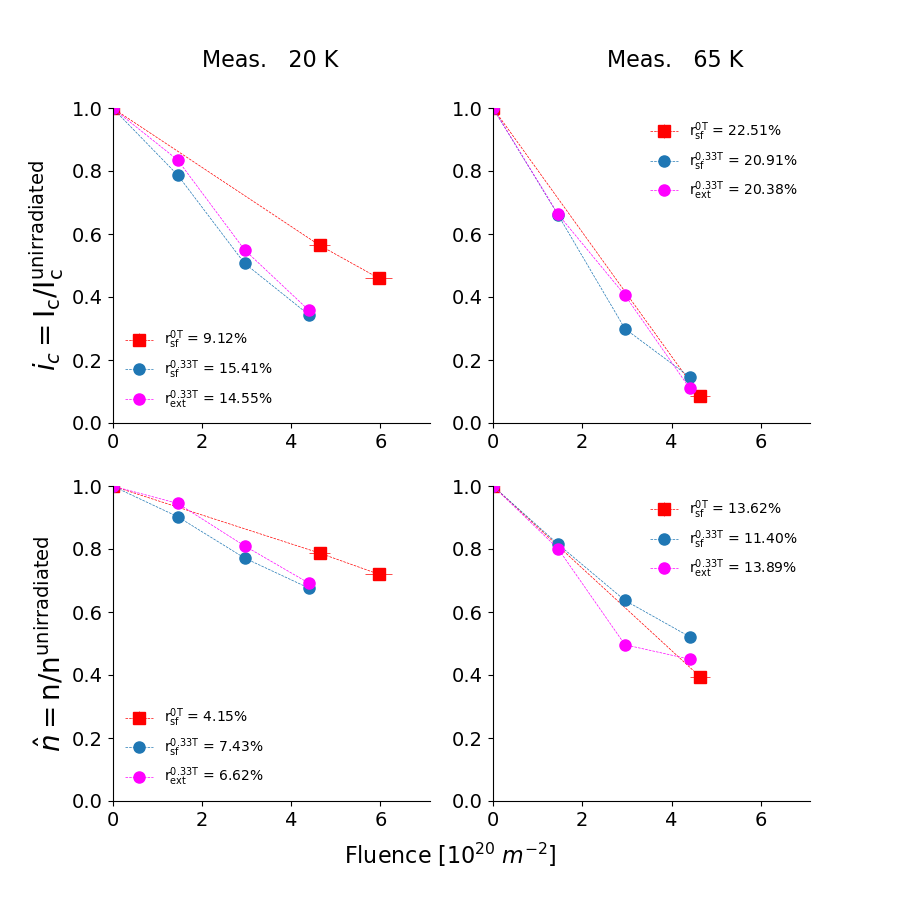

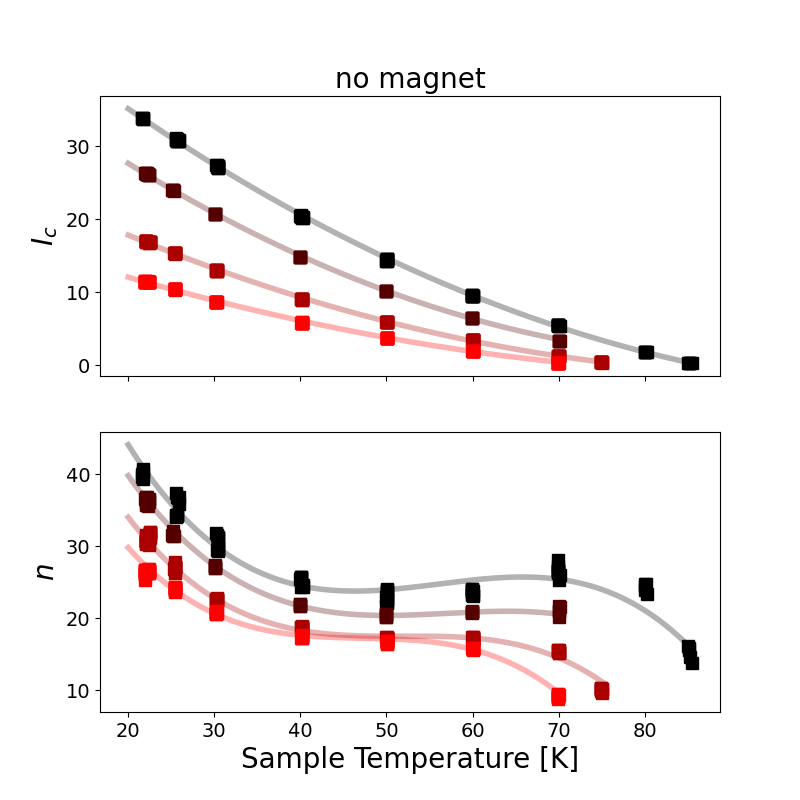

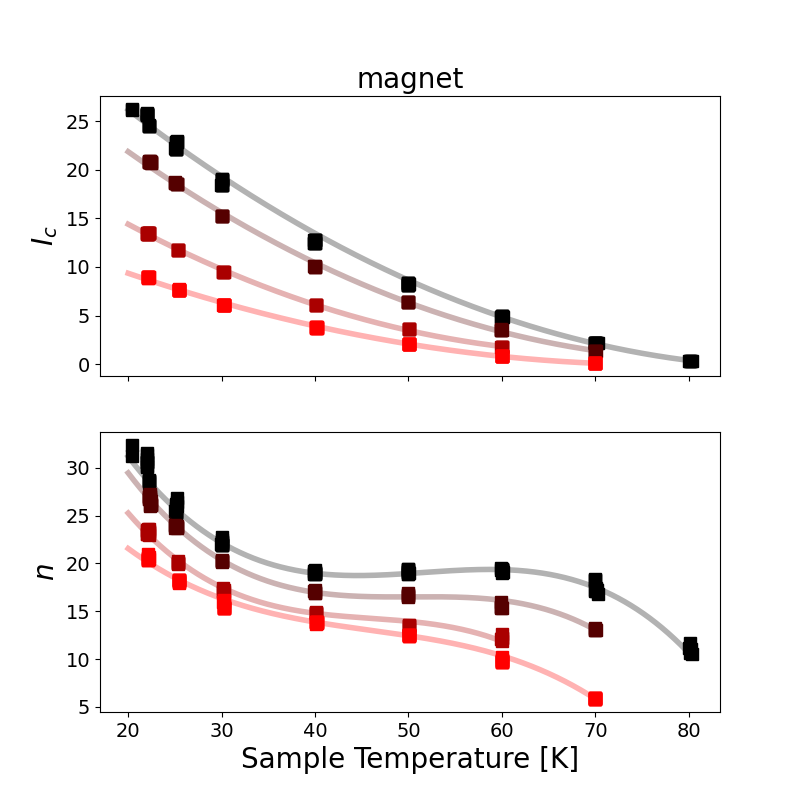

In [2]:

#############################################
#
# THESE VALUES ARE NOT UPDATED AUTOMATICALLY!!
#
loT, hiT = 20, 65
#
r_ic300k_20k = 9.12
r_n300k_20k = 4.15
r_ic300k_77k = 22.51
r_n300k_77k = 13.62
#
#############################################

fig2, ax2 = plt.subplots(2, 2, figsize=(9,9))


ax2[0][0].set_ylabel(r'$i_c = \mathrm{I_c / I_c^{unirradiated}}$')
ax2[1][0].set_ylabel(r'$\hat{n} = \mathrm{n / n^{unirradiated}}$')
for axis in ax2.flatten():
    axis.set_xlim(0, 7.1)
    axis.set_ylim(0, 1)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)


# Get the 300 K irradiation data for sample ffj26 for reference
data_ffj26 = pd.read_excel('../../chapter 5/data/output/300k_ffj26-ic_degradation.xlsx', sheet_name='aggregates')
data_20k = data_ffj26[data_ffj26.temperature_group == '[19.8, 20.2)']
data_77k = data_ffj26[data_ffj26.temperature_group == '[76.8, 77.3)']

x = data_20k.cumulated_fluence/1e20
xerr, ic0, n0 = 0.05*x, data_20k.ic_mean.iloc[0], data_20k.n_mean.iloc[0]
ax2[0][0].errorbar(x=x, xerr=xerr, y=data_20k.ic_mean/ic0, yerr=data_20k.ic_std/ic0, color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathrm{r_{sf}^{0 T}}$'+' = {:4.2f}%'.format(r_ic300k_20k))
ax2[1][0].errorbar(x=x, xerr=xerr, y=data_20k.n_mean/n0, yerr=data_20k.ic_std/n0, color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathrm{r_{sf}^{0 T}}$'+' = {:4.2f}%'.format(r_n300k_20k))
    
x = data_77k.cumulated_fluence/1e20
xerr = xerr, ic0, n0 = 0.05*x, data_77k.ic_mean.iloc[0], data_77k.n_mean.iloc[0]
ax2[0][1].errorbar(x=x, xerr=xerr, y=data_77k.ic_mean/ic0, yerr=data_77k.ic_std/ic0, color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathrm{r_{sf}^{0 T}}$'+' = {:4.2f}%'.format(r_ic300k_77k))
ax2[1][1].errorbar(x=x, xerr=xerr, y=data_77k.n_mean/n0, yerr=data_77k.ic_std/n0, color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathrm{r_{sf}^{0 T}}$'+' = {:4.2f}%'.format(r_n300k_77k))


palette = sns.color_palette('blend:black,red', 4)

fluence = pd.read_excel('/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 6/data/ext_ffj51/fluence/Proton_2025_03_27_Alexis_ffj51.xlsx', sheet_name='fluence_steps', usecols=[0, 1, 2], names=['step', 'step_fluence', 'cumulated_fluence'])
fluence = fluence.cumulated_fluence[[0, 3, 6, 9]]/1e20

for magnet, mc in zip(['no magnet', 'magnet'], ['C0', 'magenta']):
    ic20k, ic70k, n20k, n70k = [], [], [], []
    eic20k, eic70k, en20k, en70k = [], [], [], []
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].set_title(magnet)
    ax[1].set_xlabel('Sample Temperature [K]')
    ax[0].set_ylabel('$I_c$')
    ax[1].set_ylabel('$n$')
    #ax[0].set_ylim(0, 30)
    #ax[0].set_xlim(20, 90)
    #ax[1].set_ylim(0, 35)
    #ax[1].set_xlim(20, 90)

    for c, step in zip(palette, ['step00', 'step03', 'step06', 'step09']):
        path = 'ext_ffj51/Ic/infield/{}/{}/'.format(step, magnet)
        
        _, _, data, popt_ic, popt_n = hts.getIcT([path+f for f in np.sort(os.listdir(path)) if 'Ic_' in f], fit=True, function='powerLaw')
        xsmooth = np.linspace(20, data.temperature.max(), 1000)

        ax[0].plot(xsmooth, ff.quadratic(xsmooth, *popt_ic), linewidth=4, alpha=.3, color=c)
        ax[0].plot(data.temperature, data.ic, marker='s', linestyle='None', label=step, color=c)

        ax[1].plot(xsmooth, ff.cubic(xsmooth, *popt_n), linewidth=4, alpha=.3, color=c)
        ax[1].plot(data.temperature, data.n, marker='s', linestyle='None', label=step, color=c)
        
        ic20k.append(ff.quadratic(loT, *popt_ic))
        ic70k.append(ff.quadratic(hiT, *popt_ic))
        n20k.append(ff.cubic(loT, *popt_n))
        n70k.append(ff.cubic(hiT, *popt_n))

        #eic20k.append(ff.quadratic(20, *popt_ic))
        #eic70k.append(ff.quadratic(70, *popt_ic))
        #en20k.append(ff.cubic(20, *popt_n))
        #en70k.append(ff.cubic(70, *popt_n))
   
    for i, (y, axis) in enumerate(zip([ic20k/ic20k[0], ic70k/ic70k[0], n20k/n20k[0], n70k/n70k[0]], ax2.flatten())):
        x, y = np.array(fluence), np.array(y) 
        x, y = fluence[y > 0], y[y > 0]
        popt, pcov = optimize.curve_fit(ff.norm_linear, x, y)
        if magnet == 'magnet':
            axis.errorbar(x=x, y=y/y[0], linestyle='--', linewidth=.5, marker='o', color=mc, label=r'$\mathrm{r_{ext}^{0.33 T}}$'+' = {:4.2f}%'.format(100*popt[0]))
        else:
            axis.errorbar(x=x, y=y/y[0], linestyle='--', linewidth=.5, marker='o', color=mc, label=r'$\mathrm{r_{sf}^{0.33 T}}$'+' = {:4.2f}%'.format(100*popt[0]))

        if i%2 == 1:
            axis.legend(frameon=False, loc='upper right', fontsize=10)
        else:
            axis.legend(frameon=False, loc='lower left', fontsize=10)

#ax2[1][0].legend(loc='lower left', frameon=False)
fig2.text(0.5, 0.04, 'Fluence [10$^{20}\; m^{-2}$]', ha='center', fontsize=16)
fig2.text(0.3, 0.92, "Meas. {:4.0f} K".format(loT), ha='center', va='bottom', fontsize=16)
fig2.text(0.75, 0.92, "Meas. {:4.0f} K".format(hiT), ha='center', va='bottom', fontsize=16)

fig2.savefig(savedir+'icnf_20k_70k.png', transparent=True, dpi=300)

## Critical temperature degradation with and without magnet

[-0.01639251]
[-0.02991299]
[-0.02876956]


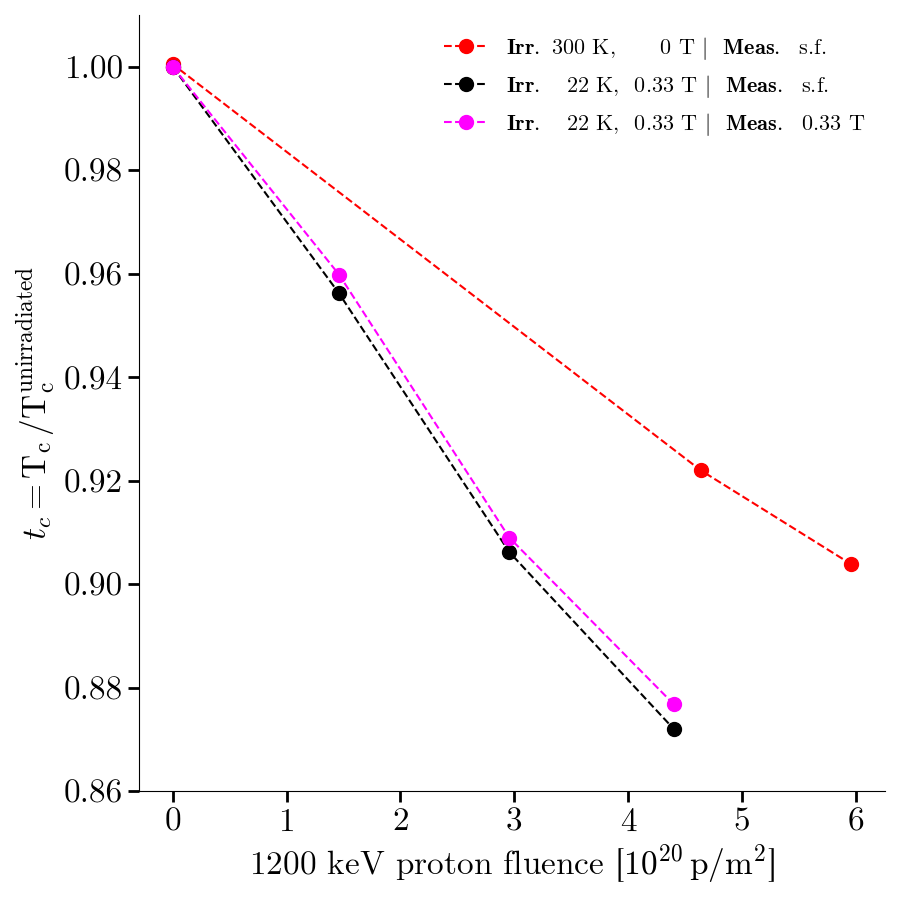

In [48]:
fig, ax = plt.subplots()
ax.set_ylim(.86, 1.01)
ax.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20}\, p/m^2}$]')
ax.set_ylabel(r'$t_c \mathrm{= T_c \, / T_c^{unirradiated}}$')

fpaths = [
    '/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/chapter 5/data/output/300k_ffj26-tc_degradation.xlsx',
    'output/ext_ffj51-tc_degradation.xlsx',
    'output/ext_ffj51-tc_degradation.xlsx'
]

labels = [
    r'$\mathbf{Irr.}$ 300 K,      0 T |  $\mathbf{Meas.}$  s.f.', 
    r'$\mathbf{Irr.}$   22 K,  0.33 T |  $\mathbf{Meas.}$  s.f.',
    r'$\mathbf{Irr.}$   22 K,  0.33 T |  $\mathbf{Meas.}$  0.33 T',
    
]
r'$\mathbf{Irr.}$   22 K, 0.33 T |'

for fpath, c, l, magnet in zip(fpaths, ['r', 'k', 'magenta'], labels, [False, False, True]):
    data = pd.read_excel(fpath)
    
    if 'magnet' in data.columns:
        data = data[data.magnet == magnet]
        
    tc0 = data[data.cumulated_fluence == 0].tc.values[0]
    
    ax.plot(data.cumulated_fluence/1e20, data.tc/tc0, marker='o', linestyle='--', color=c, label=l)

    icpopt, _ = optimize.curve_fit(linear_norm, np.array(data.cumulated_fluence)/1e20, data.tc/tc0)
    xsmooth = np.arange(0, data.cumulated_fluence.max()/1e20+1, 1)
    ysmooth = linear_norm(xsmooth, *icpopt)
    #ax.plot(xsmooth, ysmooth, color=c, zorder=0, linewidth=4, alpha=.3, solid_capstyle='round')
    print(icpopt)
    
fig.tight_layout()
ax.legend(loc='upper right', frameon=False)
fig.savefig(savedir+r'tc_field_nofield.svg', format='svg', dpi=300, transparent=True)


## Critical current degradation with and without magnet

In [13]:
tape_data = pd.read_excel('output/{}-ic_degradation.xlsx'.format('ext_ffj51'), sheet_name='aggregates')
tape_data[tape_data.temperature_group == '[22.5, 22.7)']

,temperature_group,cumulated_fluence,magnet,temperature_mean,temperature_std,ic_mean,ic_std,n_mean,n_std,file_count
18,"[22.5, 22.7)",2.956244e+20,False,22.528396,0.011671,16.840943,0.026013,31.623565,0.35388,5


<>:11: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:11: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_83915/749053341.py:11: SyntaxWarning: invalid escape sequence '\;'
  ax2.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(loT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_83915/749053341.py:19: SyntaxWarning: invalid escape sequence '\;'
  ax3.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(hiT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')


ext_ffj51 Ic0 =  26.178896001503134 0.07407615291081222
ext_ffj51 Ic0 =  35.161283414652836 0.08227199227999889


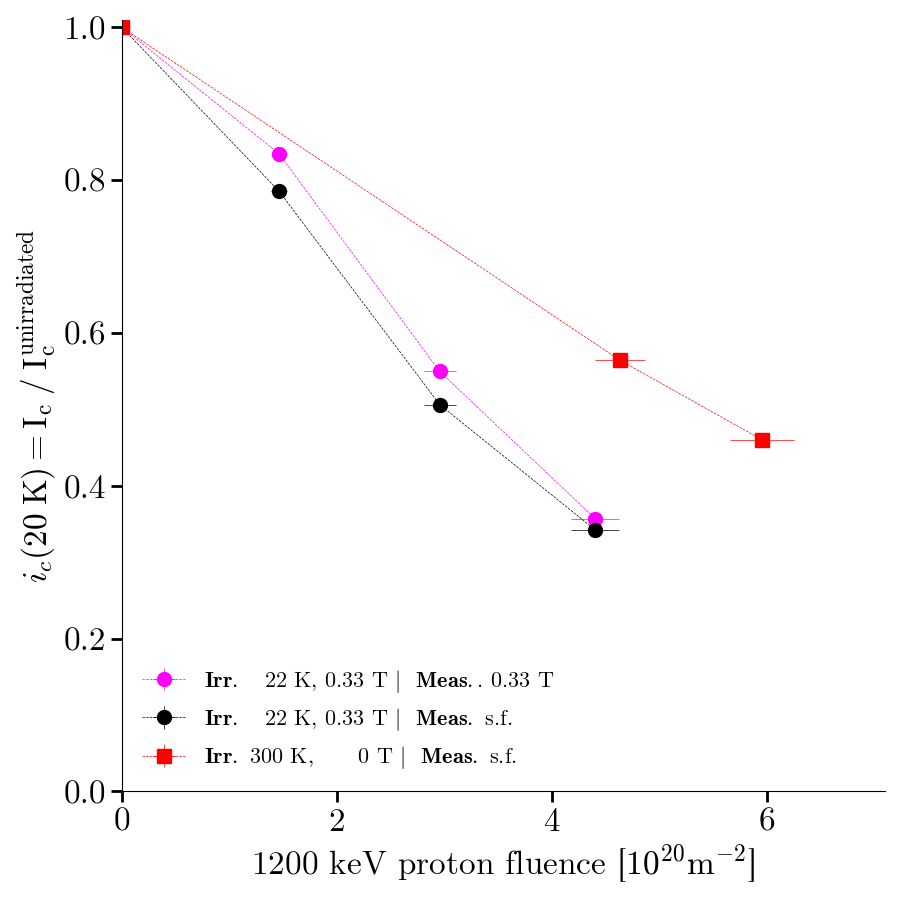

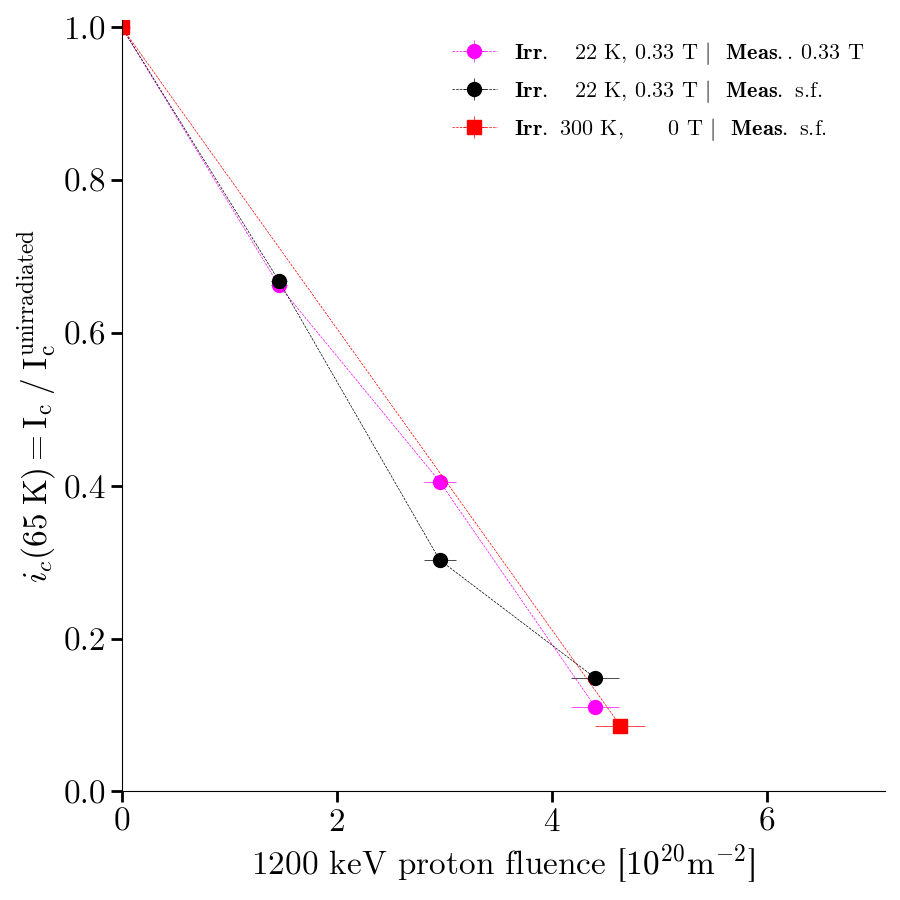

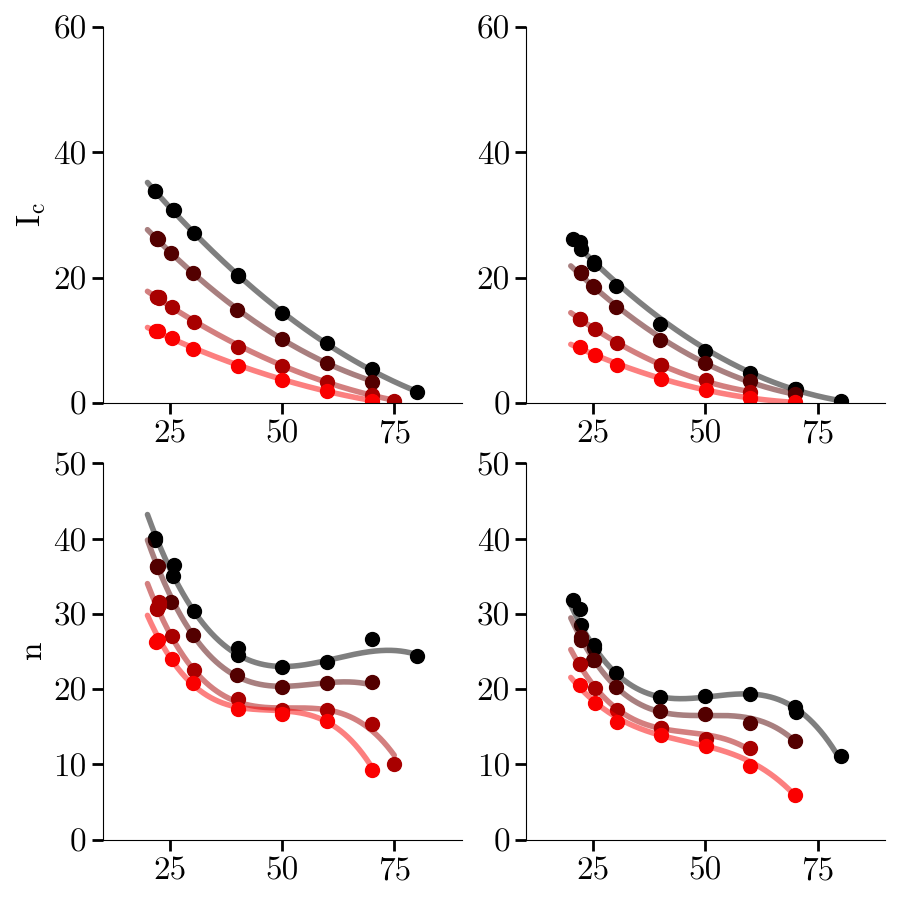

In [49]:
loT, hiT = 20, 65

palette = sns.color_palette('blend:black,red', as_cmap=True)

fig2, ax2 = plt.subplots(figsize=(9, 9))
ax2.set_xlim(0, 7.1)
ax2.set_ylim(0, 1.01)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20} m^{-2}}$]')
ax2.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(loT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')

fig3, ax3 = plt.subplots(figsize=(9, 9))
ax3.set_xlim(0, 7.1)
ax3.set_ylim(0, 1.01)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20} m^{-2}}$]')
ax3.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(hiT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')


for tape, m in zip(['ext_ffj51', 'slf_ffj54'], ['o']):#, 'X']): # 'ext_ffj50'
    
    fig, ax = plt.subplots(2, 2)
    ax[0][0].set_ylabel(r'$\mathrm{I_c}$')
    ax[1][0].set_ylabel(r'$\mathrm{n}$')
    for axis in ax.flatten():
        axis.set_xlim(10, 90)
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
    ax[0][0].set_ylim(0, 60)
    ax[0][1].set_ylim(0, 60)
    ax[1][0].set_ylim(0, 50)
    ax[1][1].set_ylim(0, 50)
    
    tape_data = pd.read_excel('output/{}-ic_degradation.xlsx'.format(tape), sheet_name='aggregates')
    fluence = tape_data.cumulated_fluence.unique()/1e20

    lo_ic_ext, lo_n_ext, hi_ic_ext, hi_n_ext = [], [], [], []
    lo_ic_slf, lo_n_slf, hi_ic_slf, hi_n_slf = [], [], [], []
    
    for i, df in enumerate([tape_data[~tape_data.magnet], tape_data[tape_data.magnet]]):
        for f in fluence:
            data, c = df[df.cumulated_fluence/1e20==f], palette(f/4.5)
            
            xsmooth = np.linspace(20, data.temperature_mean.max(), 1000)

            popt_ic, pcov_ic = optimize.curve_fit(ff.quadratic, data.temperature_mean, data.ic_mean, sigma=data.ic_std, absolute_sigma=True)
            popt_n, pcov_n = optimize.curve_fit(ff.cubic, data.temperature_mean, data.n_mean, sigma=data.n_std, absolute_sigma=True)

            ax[0][i].plot(xsmooth, ff.quadratic(xsmooth, *popt_ic), linewidth=4, alpha=.5, color=c, solid_capstyle='round')
            ax[0][i].plot(data.temperature_mean, data.ic_mean, marker='o', linestyle='None', color=c)

            ax[1][i].plot(xsmooth, ff.cubic(xsmooth, *popt_n), linewidth=4, alpha=.5, color=c, solid_capstyle='round')
            ax[1][i].plot(data.temperature_mean, data.n_mean, marker='o', linestyle='None', color=c)
            
            if data.magnet.all():
                lo_ic_ext.append(ff.quadratic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                lo_n_ext.append(ff.cubic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
                hi_ic_ext.append(ff.quadratic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                hi_n_ext.append(ff.cubic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
            else:
                lo_ic_slf.append(ff.quadratic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                lo_n_slf.append(ff.cubic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
                hi_ic_slf.append(ff.quadratic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                hi_n_slf.append(ff.cubic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))

    if tape[:3] == 'ext':
        l1 = r'$\mathbf{Irr.}$   22 K, 0.33 T |'
    else:
        l1 = r'$\mathbf{Irr.}$   22 K,      0 T |'

    for data, c, l2 in zip([lo_ic_ext, lo_ic_slf], ['magenta', 'k'], [r'  $\mathbf{Meas.}$. 0.33 T', r'  $\mathbf{Meas.}$ s.f.']):
        ymean, ystd = np.array([d.n for d in data]), np.array([d.s for d in data])
        ax2.errorbar(x=fluence, xerr=0.05*fluence, y=ymean/ymean[0], yerr=ystd/ymean[0], label=l1+l2, marker=m, color=c, linestyle='--', linewidth=.5)
        print('{} Ic0 = '.format(tape), ymean[0], ystd[0])
            
    for data, c, l2 in zip([hi_ic_ext, hi_ic_slf], ['magenta', 'k'], [r'  $\mathbf{Meas.}$. 0.33 T', r'  $\mathbf{Meas.}$ s.f.']):
        ymean, ystd = np.array([d.n for d in data]), np.array([d.s for d in data])
        ax3.errorbar(x=fluence, xerr=0.05*fluence, y=ymean/ymean[0], yerr=ystd/ymean[0], label=l1+l2, marker=m, color=c, linestyle='--', linewidth=.5)
             
    fig.tight_layout()
    fig.savefig(savedir+'icntfb_{}.png'.format(tape), transparent=False, dpi=300)


# plot the 300 K irradiation data ffj26
data_ffj26 = pd.read_excel('../../chapter 5/data/output/300k_ffj26-ic_degradation.xlsx', sheet_name='aggregates')
data_20k = data_ffj26[data_ffj26.temperature_group == '[19.8, 20.2)']
data_77k = data_ffj26[data_ffj26.temperature_group == '[76.8, 77.3)']
x = data_20k.cumulated_fluence/1e20
xerr = 0.05*x
ax2.errorbar(x=x, xerr=xerr, y=data_20k.ic_mean/data_20k.ic_mean.iloc[0], yerr=data_20k.ic_std/data_20k.ic_mean.iloc[0], color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathbf{Irr.}$ 300 K,      0 T |  $\mathbf{Meas.}$ s.f.')
x = data_77k.cumulated_fluence/1e20
xerr = 0.05*x
ax3.errorbar(x=x, xerr=xerr, y=data_77k.ic_mean/data_77k.ic_mean.iloc[0], yerr=data_77k.ic_std/data_77k.ic_mean.iloc[0], color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathbf{Irr.}$ 300 K,      0 T |  $\mathbf{Meas.}$ s.f.')

fig2.tight_layout()
fig3.tight_layout()
ax2.legend(loc='lower left', frameon=False, fontsize=16)
ax3.legend(loc='upper right', frameon=False, fontsize=16)
fig2.savefig(savedir+'irradiated_wo_field_{}K-exec.png'.format(loT), transparent=False, dpi=300)
fig3.savefig(savedir+'irradiated_wo_field_{}K-exec.png'.format(hiT), transparent=False, dpi=300)

<>:11: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_83915/2538857709.py:11: SyntaxWarning: invalid escape sequence '\;'
  ax2.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(loT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_83915/2538857709.py:19: SyntaxWarning: invalid escape sequence '\;'
  ax3.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(hiT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_83915/2538857709.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax[0][i].

  $\mathbf{Meas.}$ 0.33 T [-0.21894551]
  $\mathbf{Meas.}$ s.f. [-0.21122565]


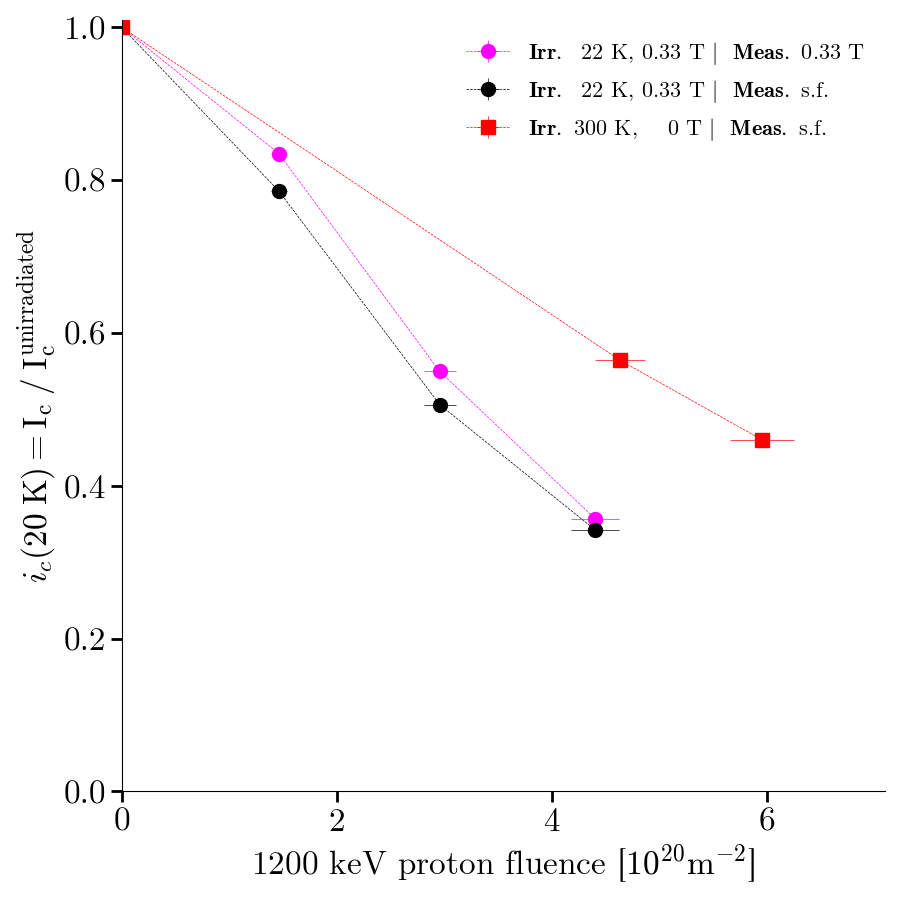

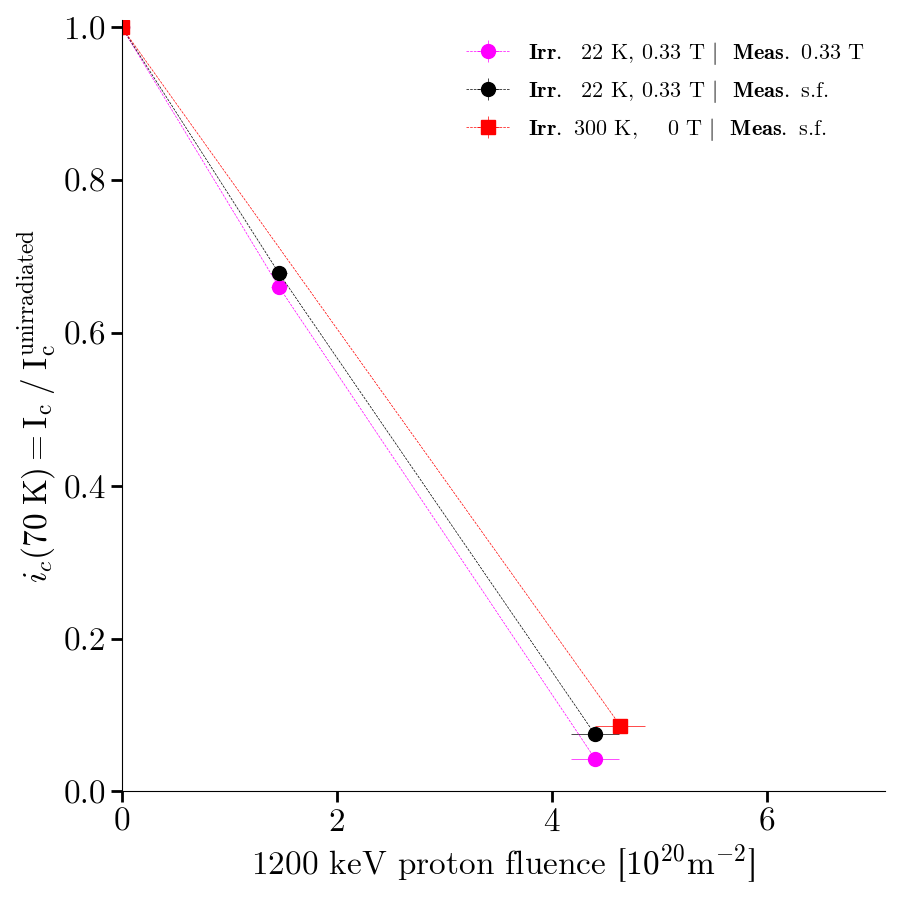

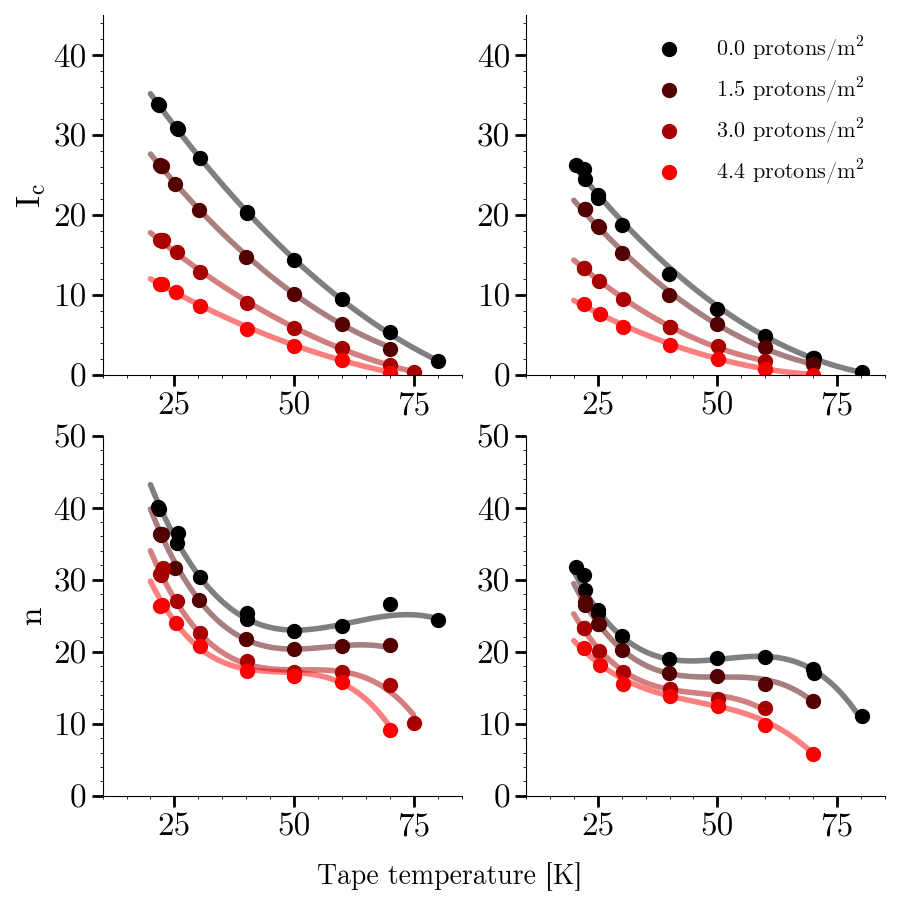

In [57]:
loT, hiT = 20, 70

palette = sns.color_palette('blend:black,red', as_cmap=True)

fig2, ax2 = plt.subplots(figsize=(9, 9))
ax2.set_xlim(0, 7.1)
ax2.set_ylim(0, 1.01)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20} m^{-2}}$]')
ax2.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(loT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')

fig3, ax3 = plt.subplots(figsize=(9, 9))
ax3.set_xlim(0, 7.1)
ax3.set_ylim(0, 1.01)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20} m^{-2}}$]')
ax3.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(hiT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')


for tape, m in zip(['ext_ffj51', 'slf_ffj54'], ['o']):#, 'X']): # 'ext_ffj50'
    
    fig, ax = plt.subplots(2, 2)
    fig.supxlabel('Tape temperature [K]')
    ax[0][0].set_ylabel(r'$\mathrm{I_c}$')
    ax[1][0].set_ylabel(r'$\mathrm{n}$')
    for axis in ax.flatten():
        axis.set_xlim(10, 85)
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.minorticks_on()
    ax[0][0].set_ylim(0, 45)
    ax[0][1].set_ylim(0, 45)
    ax[1][0].set_ylim(0, 50)
    ax[1][1].set_ylim(0, 50)
    
    
    tape_data = pd.read_excel('output/{}-ic_degradation.xlsx'.format(tape), sheet_name='aggregates')
    fluence = tape_data.cumulated_fluence.unique()/1e20

    lo_ic_ext, lo_n_ext, hi_ic_ext, hi_n_ext = [], [], [], []
    lo_ic_slf, lo_n_slf, hi_ic_slf, hi_n_slf = [], [], [], []
    
    for i, df in enumerate([tape_data[~tape_data.magnet], tape_data[tape_data.magnet]]):
        for f in fluence:
            data, c = df[df.cumulated_fluence/1e20==f], palette(f/4.5)
            
            xsmooth = np.linspace(20, data.temperature_mean.max(), 1000)

            popt_ic, pcov_ic = optimize.curve_fit(ff.quadratic, data.temperature_mean, data.ic_mean, sigma=data.ic_std, absolute_sigma=True)
            popt_n, pcov_n = optimize.curve_fit(ff.cubic, data.temperature_mean, data.n_mean, sigma=data.n_std, absolute_sigma=True)

            ax[0][i].plot(xsmooth, ff.quadratic(xsmooth, *popt_ic), linewidth=4, alpha=.5, color=c, solid_capstyle='round')
            ax[0][i].plot(data.temperature_mean, data.ic_mean, marker='o', linestyle='None', color=c, label='{:4.1f}'.format(f)+' protons/m$^\mathrm{2}$')

            ax[1][i].plot(xsmooth, ff.cubic(xsmooth, *popt_n), linewidth=4, alpha=.5, color=c, solid_capstyle='round')
            ax[1][i].plot(data.temperature_mean, data.n_mean, marker='o', linestyle='None', color=c, label='{:4.1f}'.format(f)+' protons/m$^\mathrm{2}$')
            
            if data.magnet.all():
                lo_ic_ext.append(ff.quadratic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                lo_n_ext.append(ff.cubic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
                hi_ic_ext.append(ff.quadratic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                hi_n_ext.append(ff.cubic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
            else:
                lo_ic_slf.append(ff.quadratic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                lo_n_slf.append(ff.cubic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
                hi_ic_slf.append(ff.quadratic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                hi_n_slf.append(ff.cubic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))

    if tape[:3] == 'ext':
        l1 = r'$\mathbf{Irr.}$  22 K, 0.33 T |'
    else:
        l1 = r'$\mathbf{Irr.}$  22 K,      0 T |'

    
    for data, c, l2 in zip([lo_ic_ext, lo_ic_slf], ['magenta', 'k'], [r'  $\mathbf{Meas.}$ 0.33 T', r'  $\mathbf{Meas.}$ s.f.']):
        ymean, ystd = np.array([d.n for d in data]), np.array([d.s for d in data])
        ax2.errorbar(x=fluence, xerr=0.05*fluence, y=ymean/ymean[0], yerr=ystd/ymean[0], label=l1+l2, marker=m, color=c, linestyle='--', linewidth=.5)
        #print('{} Ic0 = '.format(tape), ymean[0], ystd[0])
        

    cut = (fluence < 2) | (4 < fluence)
    for data, c, l2 in zip([hi_ic_ext, hi_ic_slf], ['magenta', 'k'], [r'  $\mathbf{Meas.}$ 0.33 T', r'  $\mathbf{Meas.}$ s.f.']):
        ymean, ystd = np.array([d.n for d in data]), np.array([d.s for d in data])
        x, xerr = fluence[cut], fluence[cut]*0.05
        y, yerr = ymean[cut]/ymean[0], ystd[cut]/ymean[0]
        ax3.errorbar(x=x, xerr=xerr, y=y, yerr=yerr, label=l1+l2, marker=m, color=c, linestyle='--', linewidth=.5)
        icpopt, _ = optimize.curve_fit(linear_norm, x, y)
        print(l2, icpopt)
        
    ax[0][1].legend(loc='upper right', frameon=False)
    fig.tight_layout()
    fig.savefig(savedir+'icntfb_{}.svg'.format(tape), format='svg', transparent=False, dpi=300)


# plot the 300 K irradiation data ffj26
data_ffj26 = pd.read_excel('../../chapter 5/data/output/300k_ffj26-ic_degradation.xlsx', sheet_name='aggregates')
data_20k = data_ffj26[data_ffj26.temperature_group == '[19.8, 20.2)']
data_77k = data_ffj26[data_ffj26.temperature_group == '[76.8, 77.3)']
x = data_20k.cumulated_fluence/1e20
xerr = 0.05*x
ax2.errorbar(x=x, xerr=xerr, y=data_20k.ic_mean/data_20k.ic_mean.iloc[0], yerr=data_20k.ic_std/data_20k.ic_mean.iloc[0], color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathbf{Irr.}$ 300 K,    0 T |  $\mathbf{Meas.}$ s.f.')
x = data_77k.cumulated_fluence/1e20
xerr = 0.05*x
ax3.errorbar(x=x, xerr=xerr, y=data_77k.ic_mean/data_77k.ic_mean.iloc[0], yerr=data_77k.ic_std/data_77k.ic_mean.iloc[0], color='r', marker='s', linestyle='--', linewidth=.5, label=r'$\mathbf{Irr.}$ 300 K,    0 T |  $\mathbf{Meas.}$ s.f.')


fig2.tight_layout()
fig3.tight_layout()
ax2.legend(loc='upper right', frameon=False, fontsize=16)
ax3.legend(loc='upper right', frameon=False, fontsize=16)
fig2.savefig(savedir+'irradiated_wo_field_{}K.png'.format(loT), format='png', transparent=False, dpi=300)
fig3.savefig(savedir+'irradiated_wo_field_{}K.png'.format(hiT), format='png', transparent=False, dpi=300)

## For defense

<>:13: SyntaxWarning: invalid escape sequence '\;'
<>:21: SyntaxWarning: invalid escape sequence '\;'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\;'
<>:21: SyntaxWarning: invalid escape sequence '\;'
<>:53: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_3339/452971977.py:13: SyntaxWarning: invalid escape sequence '\;'
  ax2.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(loT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_3339/452971977.py:21: SyntaxWarning: invalid escape sequence '\;'
  ax3.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(hiT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_3339/452971977.py:53: SyntaxWarning: invalid escape sequence '\m'
  l1 = r'$\mathbf{Irr.}$   22 K, 0.33 T |'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_3339/452971977.py

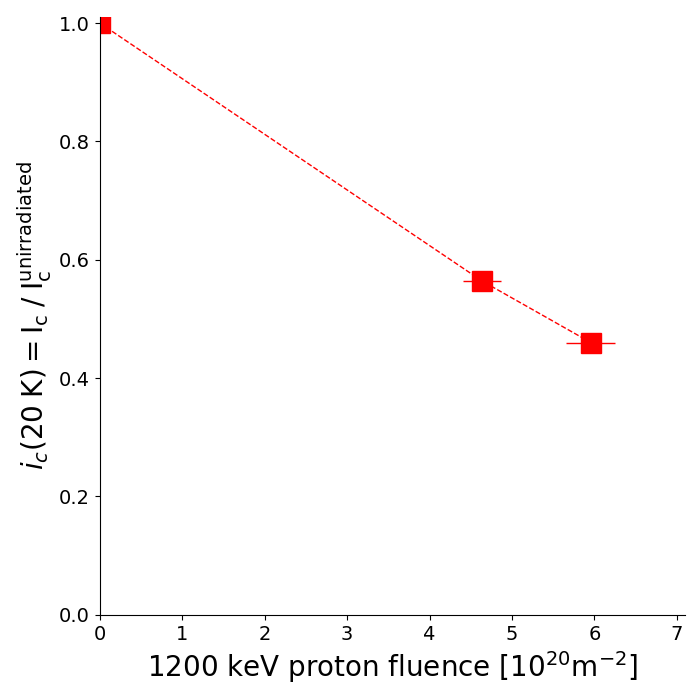

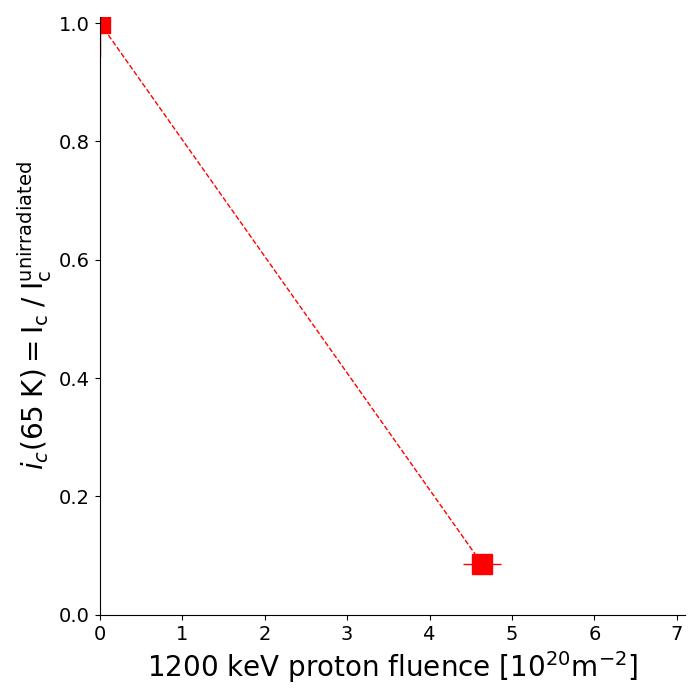

In [12]:
savedir = '/Users/alexisdevitre/Desktop/phd-defense/'

loT, hiT = 20, 65

palette = sns.color_palette('blend:black,red', as_cmap=True)

fig2, ax2 = plt.subplots(figsize=(7, 7))
ax2.set_xlim(0, 7.1)
ax2.set_ylim(0, 1.01)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20} m^{-2}}$]')
ax2.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(loT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')

fig3, ax3 = plt.subplots(figsize=(7, 7))
ax3.set_xlim(0, 7.1)
ax3.set_ylim(0, 1.01)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel(r'1200 keV proton fluence [$\mathrm{10^{20} m^{-2}}$]')
ax3.set_ylabel(r'$i_c\mathrm{('+'{:4.0f}'.format(hiT)+'\; K) = I_c \; / \; I_c^{unirradiated}}$')

'''
for tape, m in zip(['ext_ffj51'], ['o']): # 'ext_ffj50'
    
    tape_data = pd.read_excel('output/{}-ic_degradation.xlsx'.format(tape), sheet_name='aggregates')
    fluence = tape_data.cumulated_fluence.unique()/1e20

    lo_ic_ext, lo_n_ext, hi_ic_ext, hi_n_ext = [], [], [], []
    lo_ic_slf, lo_n_slf, hi_ic_slf, hi_n_slf = [], [], [], []
    
    for i, df in enumerate([tape_data[~tape_data.magnet], tape_data[tape_data.magnet]]):
        for f in fluence:
            data, c = df[df.cumulated_fluence/1e20==f], palette(f/4.5)
            
            xsmooth = np.linspace(20, data.temperature_mean.max(), 1000)

            popt_ic, pcov_ic = optimize.curve_fit(ff.quadratic, data.temperature_mean, data.ic_mean, sigma=data.ic_std, absolute_sigma=True)
            popt_n, pcov_n = optimize.curve_fit(ff.cubic, data.temperature_mean, data.n_mean, sigma=data.n_std, absolute_sigma=True)

            if data.magnet.all():
                lo_ic_ext.append(ff.quadratic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                lo_n_ext.append(ff.cubic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
                hi_ic_ext.append(ff.quadratic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                hi_n_ext.append(ff.cubic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
            else:
                lo_ic_slf.append(ff.quadratic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                lo_n_slf.append(ff.cubic(ufloat(loT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))
                hi_ic_slf.append(ff.quadratic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_ic, np.diagonal(pcov_ic))]))
                hi_n_slf.append(ff.cubic(ufloat(hiT, 0.1), *[ufloat(n, s) for n, s in zip(popt_n, np.diagonal(pcov_n))]))

    if tape[:3] == 'ext':
        l1 = r'$\mathbf{Irr.}$   22 K, 0.33 T |'
    else:
        l1 = r'$\mathbf{Irr.}$   22 K,      0 T |'

    ymean, ystd = np.array([d.n for d in lo_ic_slf]), np.array([d.s for d in lo_ic_slf])
    ax2.errorbar(x=fluence, xerr=0.05*fluence, y=ymean/ymean[0], yerr=ystd/ymean[0], marker='o', markersize=15, color='magenta', linestyle='--', linewidth=1)
    print('{} Ic0 = '.format(tape), ymean[0], ystd[0])
        
    ymean, ystd = np.array([d.n for d in hi_ic_slf]), np.array([d.s for d in hi_ic_slf])
    ax3.errorbar(x=fluence, xerr=0.05*fluence, y=ymean/ymean[0], yerr=ystd/ymean[0], marker='o', markersize=15, color='magenta', linestyle='--', linewidth=1)
'''
# plot the 300 K irradiation data ffj26
data_ffj26 = pd.read_excel('../../chapter 5/data/output/300k_ffj26-ic_degradation.xlsx', sheet_name='aggregates')
data_20k = data_ffj26[data_ffj26.temperature_group == '[19.8, 20.2)']
data_77k = data_ffj26[data_ffj26.temperature_group == '[76.8, 77.3)']
x = data_20k.cumulated_fluence/1e20
xerr = 0.05*x
ax2.errorbar(x=x, xerr=xerr, y=data_20k.ic_mean/data_20k.ic_mean.iloc[0], yerr=data_20k.ic_std/data_20k.ic_mean.iloc[0], color='r', marker='s', markersize=15, linestyle='--', linewidth=1, label=r'$\mathbf{Irr.}$ 300 K,      0 T |  $\mathbf{Meas.}$ s.f.')
x = data_77k.cumulated_fluence/1e20
xerr = 0.05*x
ax3.errorbar(x=x, xerr=xerr, y=data_77k.ic_mean/data_77k.ic_mean.iloc[0], yerr=data_77k.ic_std/data_77k.ic_mean.iloc[0], color='r', marker='s', markersize=15, linestyle='--', linewidth=1, label=r'$\mathbf{Irr.}$ 300 K,      0 T |  $\mathbf{Meas.}$ s.f.')

fig2.tight_layout()
fig3.tight_layout()
fig2.savefig(savedir+'irradiated_wo_field_{}K.png'.format(loT), transparent=False, dpi=300)
fig3.savefig(savedir+'irradiated_wo_field_{}K.png'.format(hiT), transparent=False, dpi=300)